#### Deep Neural Network 알고리즘을 Python의 Numpy를 기반으로 class와 def 모듈화로 구현

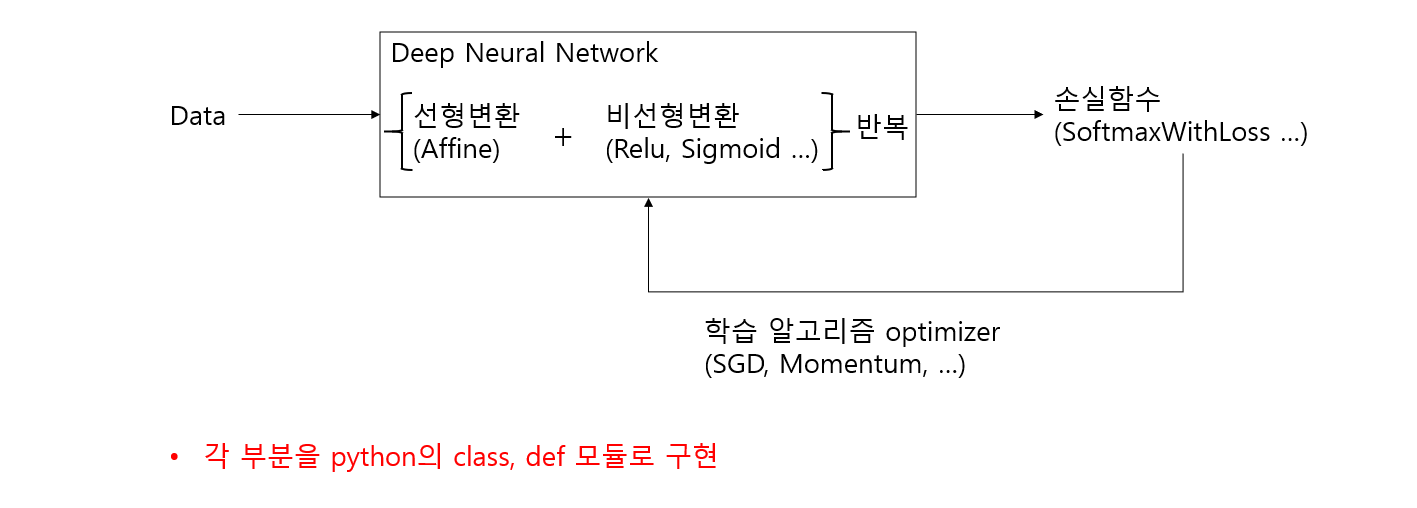

- 밑바닥부터 시작하는 딥러닝에서는 다음과 같은 class, def 모듈을 모아놓은 파일이 있음.
- 이를 사용하여 DNN을 구현해볼 것임

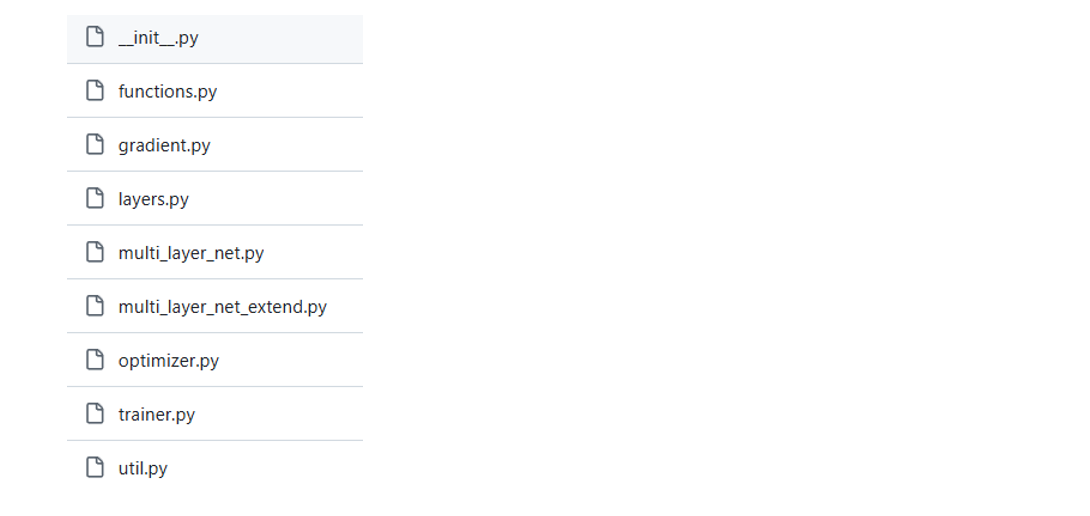

# 
- jupyter notebook 을 사용하여 다른 폴더에 py 파일들을 import 하는 과정

In [1]:
import sys, os

# 1) 현재 노트북(Project/)의 상위 폴더(2025 비교과특강/) 절대경로
base_dir = os.path.abspath(r'C:\Users\eys63\github\Nearal_Network\자료')

# 2) 중복 추가 방지 후 sys.path에 삽입
if base_dir not in sys.path:
    sys.path.append(base_dir)

# (옵션) 변경된 모듈 자동 반영
%load_ext autoreload
%autoreload 2

In [2]:
# 함수·레이어·최적화 기법 등 필요한 모듈을 한 번에 가져오기
from common.functions               import *
from common.gradient                import *
from common.layers                  import *
from common.multi_layer_net         import *
from common.multi_layer_net_extend  import *
from common.optimizer               import *
from common.trainer                 import *
from common.util                    import *

# 문제 1
## MNIST 데이터 Neural Network로 학습하기
1. [784 ,100 ,50 ,10 ] 구조를 가지는 신경망을 설계하여 학습
2. loss 는 Cross entropy 사용 (Softmax 모듈 사용)

# 
### - MNIST 데이터 로드

In [3]:
import tensorflow as tf

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


# 
#### 1-1번 문제 :
#### Train data와 Test data의 픽셀값을 0에서 1 사이로 정규화하세요.

In [4]:
# MNIST 픽셀값 정규화 (0~255 -> 0~1)
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Train data 범위:", X_train.min(), "~", X_train.max())
print("Test data 범위:", X_test.min(), "~", X_test.max())
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Train data 범위: 0.0 ~ 1.0
Test data 범위: 0.0 ~ 1.0
Train data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


# 
#### 1-2번 문제 :
#### Train data와 Test data의 shape을 784차원으로 flatten 하세요.

In [5]:
X_train = X_train.reshape(X_train.shape[0], -1)  # (60000, 784)
X_test = X_test.reshape(X_test.shape[0], -1)     # (10000, 784)

print(X_train.shape)
print(X_test.shape)
print("각 이미지의 픽셀 수:", X_train.shape[1])  # 28 * 28 = 784

(60000, 784)
(10000, 784)
각 이미지의 픽셀 수: 784


# 
#### 1-3번 문제 :
#### 다음 one-hot 인코딩 함수를 사용하여 Train, Test 의 label을 원핫 인코딩으로 변환하세요.

In [6]:
def one_hot_encode(labels, num_classes=10):
    """
    One-hot encodes a NumPy array of labels.

    Args:
    labels: A 1D NumPy array of labels.
    num_classes: The number of unique classes.

    Returns:
    A 2D NumPy array where each row is a one-hot vector representing a label.
    """

    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot

In [13]:
y_train_onehot = one_hot_encode(y_train, num_classes=10)
y_test_onehot = one_hot_encode(y_test, num_classes=10)

print(y_train_onehot.shape)
print(y_test_onehot.shape)

print(np.shape(y_train_onehot))
print(y_train_onehot[:5])

(60000, 10)
(10000, 10)
(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# 
### - MNIST를 풀기위한 신경망 설계
#### 1-4번 문제 : 아래 조건을 만족하는 MultiLayerNet 신경망을 설계하세요.
1. [784 ,100 ,50 ,10 ] 구조를 가지는 신경망을 설계하여 학습 (활성함수는 Sigmoid 사용)
2. loss 는 Cross entropy 사용 (Softmax 모듈 사용)

In [8]:
X_train_flat = X_train
X_test_flat = X_test

print("데이터 준비 완료:")
print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")
print(f"y_train_onehot shape: {y_train_onehot.shape}")
print(f"y_test_onehot shape: {y_test_onehot.shape}")

# MultiLayerNet 신경망 생성
network = MultiLayerNet(
    input_size=784,           # 입력 크기 (28x28 = 784)
    hidden_size_list=[100, 50], # 은닉층 [100, 50]
    output_size=10,           # 출력 크기 (0~9 숫자)
    activation='sigmoid',     # Sigmoid 활성화 함수
    weight_init_std='sigmoid' # Sigmoid에 적합한 Xavier 초기화
)

print("\n신경망 구조 확인:")
print(f"입력층: {network.input_size}")
print(f"은닉층: {network.hidden_size_list}")
print(f"출력층: {network.output_size}")
print(f"활성화 함수: sigmoid")
print(f"손실 함수: Cross Entropy (SoftmaxWithLoss)")

# 네트워크 설계 상세 정보
print("\n네트워크 층별 구조:")
for key, layer in network.layers.items():
    print(f"{key}: {type(layer).__name__}")

# 파라미터 크기 확인
print("\n네트워크 파라미터:")
total_params = 0
for key, param in network.params.items():
    print(f"{key}: {param.shape}")
    total_params += param.size
print(f"\n총 파라미터 개수: {total_params:,}")

# 네트워크 작동 테스트
print("\n네트워크 작동 테스트:")
# 샘플 데이터 사용
sample_x = X_train_flat[:5]  # 5개 샘플
sample_t = y_train_onehot[:5]

# Forward propagation 테스트
pred = network.predict(sample_x)
print(f"Forward propagation 결과 모양: {pred.shape}")
print(f"출력값이 0~1 사이인지 확인: {np.all((pred >= 0) & (pred <= 1))}")
print(f"각 샘플의 확률 합이 1인지 확인: {np.allclose(np.sum(pred, axis=1), 1.0)}")

# Loss 계산 테스트
loss = network.loss(sample_x, sample_t)
print(f"\nLoss 값: {loss:.4f}")

# Accuracy 계산 테스트
acc = network.accuracy(sample_x, sample_t)
print(f"Accuracy: {acc:.4f}")

# Gradient 계산 테스트
grads = network.gradient(sample_x, sample_t)
print(f"\nGradient 계산 완료:")
for key in grads.keys():
    print(f"{key}: {grads[key].shape}")


데이터 준비 완료:
X_train_flat shape: (60000, 784)
X_test_flat shape: (10000, 784)
y_train_onehot shape: (60000, 10)
y_test_onehot shape: (10000, 10)

신경망 구조 확인:
입력층: 784
은닉층: [100, 50]
출력층: 10
활성화 함수: sigmoid
손실 함수: Cross Entropy (SoftmaxWithLoss)

네트워크 층별 구조:
Affine1: Affine
Activation_function1: Sigmoid
Affine2: Affine
Activation_function2: Sigmoid
Affine3: Affine

네트워크 파라미터:
W1: (784, 100)
b1: (100,)
W2: (100, 50)
b2: (50,)
W3: (50, 10)
b3: (10,)

총 파라미터 개수: 84,060

네트워크 작동 테스트:
Forward propagation 결과 모양: (5, 10)
출력값이 0~1 사이인지 확인: False
각 샘플의 확률 합이 1인지 확인: False

Loss 값: 0.1126
Accuracy: 0.2000

Gradient 계산 완료:
W1: (784, 100)
b1: (100,)
W2: (100, 50)
b2: (50,)
W3: (50, 10)
b3: (10,)


# 
#### Mini batch 함수
- MNIST 데이터셋은 6만개 학습데이터를 가지므로 한 번에 올려서 학습하는 것이 어려움.
- 그러므로 배치 사이즈로 분할하는 미니 배치 학습 방법을 사용함.
- 아래 shuffle_batch 함수는 데이터와 레이블을 쌍으로 받아서 섞은 후 미니배치로 돌려주는 함수임.

#### 1-5번 문제 :
#### shuffle_batch 함수를 사용하여  아래 for문을 출력해봄으로써 미니 배치로 데이터를 주는 경우를 이해해보세요

In [9]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [10]:
# 1-5번 문제: shuffle_batch 함수를 사용하여 미니 배치 동작 방식 이해

print("=== 1-5번 문제: shuffle_batch 함수 동작 방식 이해 ===")

# 원본 데이터 크기 확인
print(f"전체 학습 데이터 크기: {X_train.shape}")
print(f"전체 학습 라벨 크기: {y_train.shape}")

# 배치 크기 설정
batch_size = 200
print(f"\n배치 크기: {batch_size}")
print(f"예상 배치 개수: {len(X_train) // batch_size}")

# shuffle_batch 함수 사용하여 미니 배치 확인
print("\n=== 미니 배치 동작 확인 ===")
batch_count = 0
total_samples = 0

for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
    batch_count += 1
    total_samples += len(X_batch)
    
    print(f"배치 {batch_count}:")
    print(f"  X_batch 크기: {X_batch.shape}")
    print(f"  y_batch 크기: {y_batch.shape}")
    
    # 처음 3개 배치만 자세히 보기
    if batch_count <= 3:
        print(f"  X_batch 데이터 타입: {X_batch.dtype}")
        print(f"  y_batch 데이터 타입: {y_batch.dtype}")
        print(f"  y_batch 샘플 (처음 5개): {y_batch[:5]}")
        print(f"  X_batch 값 범위: {X_batch.min():.3f} ~ {X_batch.max():.3f}")
        print()
    
    # 너무 많은 출력 방지
    if batch_count >= 10:
        print(f"  ... (총 {len(X_train) // batch_size}개 배치 중 처음 10개만 표시)")
        break

print(f"\n=== 미니 배치 동작 결과 ===")
print(f"총 배치 개수: {len(X_train) // batch_size}")
print(f"마지막 배치 크기: {len(X_train) % batch_size} (나머지 데이터)")
print(f"처리된 샘플 수 (처음 10개 배치): {total_samples}")

# shuffle_batch 함수의 특징 설명
print("\n=== shuffle_batch 함수의 특징 ===")
print("1. 데이터를 무작위로 섞어서 배치를 만듭니다 (Shuffling)")
print("2. 각 배치는 지정된 크기(batch_size)로 분할됩니다")
print("3. Generator를 사용하여 메모리 효율적으로 배치를 제공합니다")
print("4. 마지막 배치는 나머지 데이터로 구성되어 크기가 다를 수 있습니다")
print("5. 매번 호출할 때마다 다른 순서로 섞여서 제공됩니다")

# 섞임 확인을 위해 두 번 실행해보기
print("\n=== 섞임 확인 (두 번째 실행) ===")
first_batch_labels = []
second_batch_labels = []

# 첫 번째 배치 라벨 수집
for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
    first_batch_labels = y_batch[:10].copy()  # 처음 10개만
    break

# 두 번째 배치 라벨 수집
for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
    second_batch_labels = y_batch[:10].copy()  # 처음 10개만
    break

print(f"첫 번째 실행 - 첫 배치의 처음 10개 라벨: {first_batch_labels}")
print(f"두 번째 실행 - 첫 배치의 처음 10개 라벨: {second_batch_labels}")
print(f"두 실행 결과가 같은가? {np.array_equal(first_batch_labels, second_batch_labels)}")
print("→ 매번 다르게 섞여서 제공되므로 False가 나옵니다.")

=== 1-5번 문제: shuffle_batch 함수 동작 방식 이해 ===
전체 학습 데이터 크기: (60000, 784)
전체 학습 라벨 크기: (60000,)

배치 크기: 200
예상 배치 개수: 300

=== 미니 배치 동작 확인 ===
배치 1:
  X_batch 크기: (200, 784)
  y_batch 크기: (200,)
  X_batch 데이터 타입: float64
  y_batch 데이터 타입: uint8
  y_batch 샘플 (처음 5개): [6 2 8 3 4]
  X_batch 값 범위: 0.000 ~ 1.000

배치 2:
  X_batch 크기: (200, 784)
  y_batch 크기: (200,)
  X_batch 데이터 타입: float64
  y_batch 데이터 타입: uint8
  y_batch 샘플 (처음 5개): [7 8 6 2 5]
  X_batch 값 범위: 0.000 ~ 1.000

배치 3:
  X_batch 크기: (200, 784)
  y_batch 크기: (200,)
  X_batch 데이터 타입: float64
  y_batch 데이터 타입: uint8
  y_batch 샘플 (처음 5개): [0 5 4 1 6]
  X_batch 값 범위: 0.000 ~ 1.000

배치 4:
  X_batch 크기: (200, 784)
  y_batch 크기: (200,)
배치 5:
  X_batch 크기: (200, 784)
  y_batch 크기: (200,)
배치 6:
  X_batch 크기: (200, 784)
  y_batch 크기: (200,)
배치 7:
  X_batch 크기: (200, 784)
  y_batch 크기: (200,)
배치 8:
  X_batch 크기: (200, 784)
  y_batch 크기: (200,)
배치 9:
  X_batch 크기: (200, 784)
  y_batch 크기: (200,)
배치 10:
  X_batch 크기: (200, 784)
  y_batch 크기: (2

#### 1-6번 문제 :
#### 아래 조건을 만족하는 MNIST 문제를 학습해보세요.

1. 학습률은 0.1
2. 배치 사이즈는 200
3. 5 에폭 학습, 배치 사이즈로 업데이트마다 (Train data 6만개, Test data 1만개의 손실값 저장하여 학습이 끝난 후 배치 사이즈에 따른 손실값 시각화 그래프 출력)
4. 에폭마다 Train data, Test data에 대한 손실값과 정확도 출력
5. 학습이 모두 끝난 후 Train data와 Test data에 대한 손실값과 정확도 출력

=== 1-6번 문제: MNIST 신경망 학습 ===
학습 조건:
- 학습률: 0.1
- 배치 사이즈: 200
- 에폭 수: 5
- 신경망 구조: [784, 100, 50, 10]
- 활성화 함수: Sigmoid
- 손실 함수: Cross Entropy

에폭당 배치 수: 300
총 배치 수: 1500

=== 학습 시작 ===

--- Epoch 1/5 ---


Epoch 1: 100%|██████████| 300/300 [00:01<00:00, 219.48it/s]


Epoch 1 결과:
  Train Loss: 0.0343, Train Acc: 0.6335
  Test Loss:  0.0341, Test Acc:  0.6367

--- Epoch 2/5 ---


Epoch 2: 100%|██████████| 300/300 [00:01<00:00, 180.22it/s]


Epoch 2 결과:
  Train Loss: 0.0274, Train Acc: 0.7474
  Test Loss:  0.0272, Test Acc:  0.7549

--- Epoch 3/5 ---


Epoch 3: 100%|██████████| 300/300 [00:01<00:00, 226.44it/s]


Epoch 3 결과:
  Train Loss: 0.0248, Train Acc: 0.7728
  Test Loss:  0.0246, Test Acc:  0.7854

--- Epoch 4/5 ---


Epoch 4: 100%|██████████| 300/300 [00:01<00:00, 212.86it/s]


Epoch 4 결과:
  Train Loss: 0.0230, Train Acc: 0.8225
  Test Loss:  0.0227, Test Acc:  0.8345

--- Epoch 5/5 ---


Epoch 5: 100%|██████████| 300/300 [00:01<00:00, 232.47it/s]


Epoch 5 결과:
  Train Loss: 0.0220, Train Acc: 0.8275
  Test Loss:  0.0216, Test Acc:  0.8405

=== 학습 완료 ===

최종 학습 결과:
Train Data - Loss: 0.0220, Accuracy: 0.8275 (82.75%)
Test Data  - Loss: 0.0216, Accuracy: 0.8405 (84.05%)


C:\Users\eys63\AppData\Local\Temp\ipykernel_14416\3412399792.py:183: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eys63\AppData\Local\Temp\ipykernel_14416\3412399792.py:183: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eys63\AppData\Local\Temp\ipykernel_14416\3412399792.py:183: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eys63\AppData\Local\Temp\ipykernel_14416\3412399792.py:183: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eys63\AppData\Local\Temp\ipykernel_14416\3412399792.py:183: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eys63\AppData\Local\Temp\ipykernel_14416\3412399792.py:183: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) mis

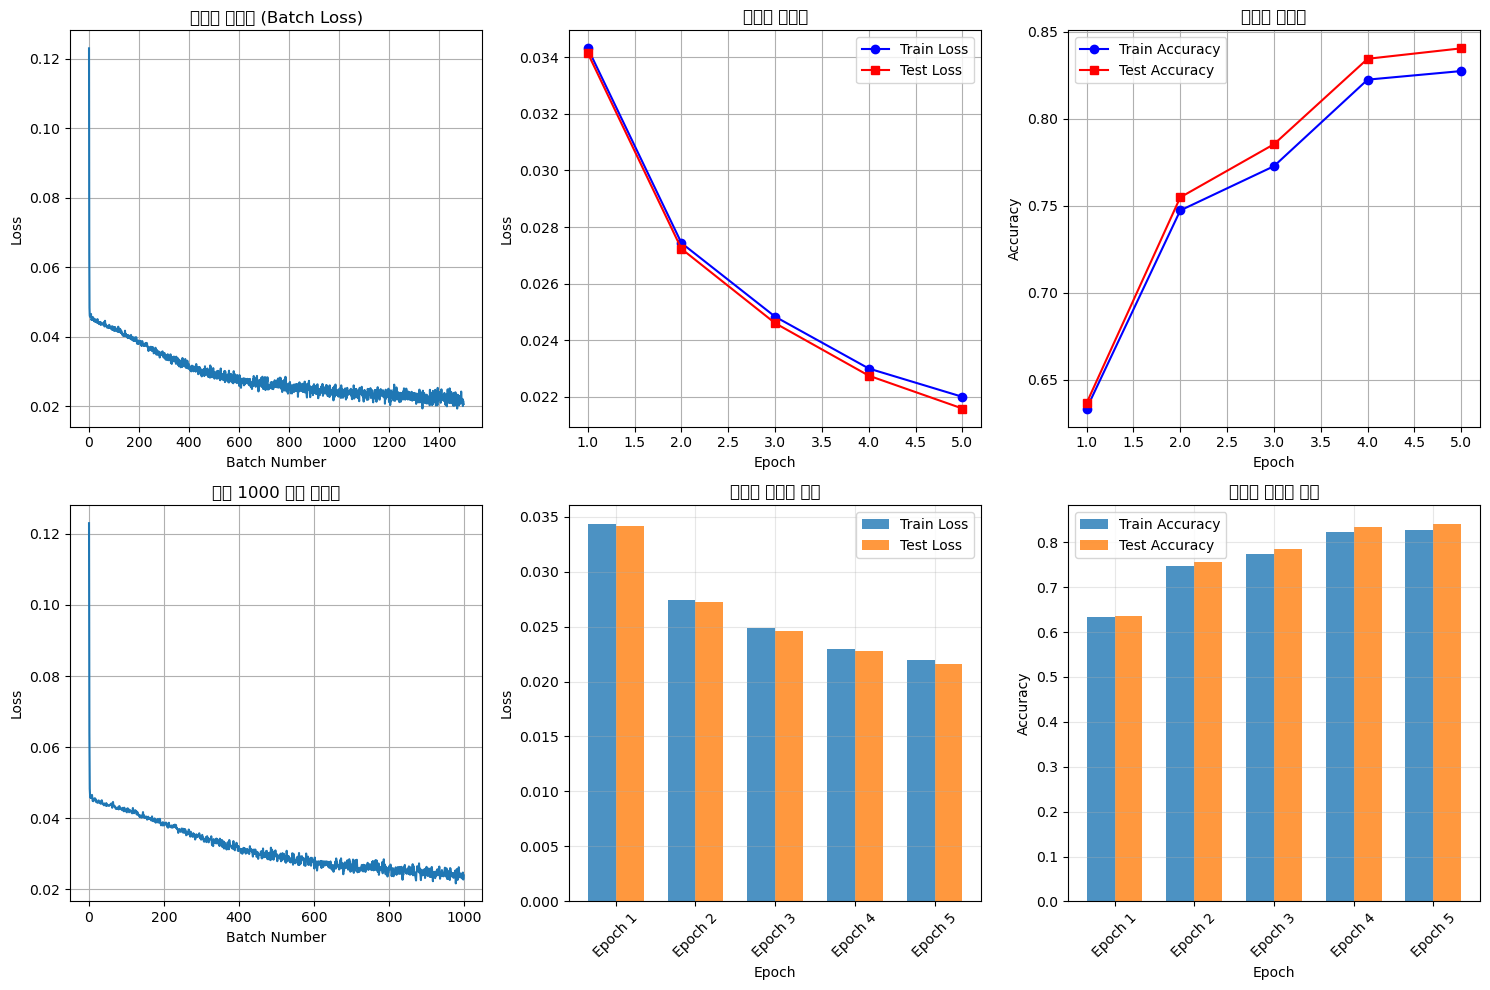


=== 학습 과정 요약 ===
처리한 총 배치 수: 1,500
처리한 총 샘플 수: 300,000
초기 배치 손실값: 0.1230
최종 배치 손실값: 0.0206
손실값 개선: 0.1024
최고 테스트 정확도: 0.8405 (84.05%)


In [ ]:
# 1-6번 문제: MNIST 문제 학습하기
# 조건:
# 1. 학습률 0.1
# 2. 배치 사이즈 200
# 3. 5 에폭 학습
# 4. 배치 업데이트마다 손실값 저장 및 시각화
# 5. 에폭마다 손실값과 정확도 출력
# 6. 학습 완료 후 최종 결과 출력

import matplotlib.pyplot as plt
from tqdm import tqdm

print("=== 1-6번 문제: MNIST 신경망 학습 ===")

# 학습 파라미터 설정
learning_rate = 0.1
batch_size = 200
epochs = 5

print(f"학습 조건:")
print(f"- 학습률: {learning_rate}")
print(f"- 배치 사이즈: {batch_size}")
print(f"- 에폭 수: {epochs}")
print(f"- 신경망 구조: [784, 100, 50, 10]")
print(f"- 활성화 함수: Sigmoid")
print(f"- 손실 함수: Cross Entropy")

# 옵티마이저 설정 (SGD)
optimizer = SGD(lr=learning_rate)

# 학습 기록을 위한 리스트
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []
batch_loss_history = []  # 배치마다 손실값 기록

# 에폭당 배치 수 계산
batches_per_epoch = len(X_train_flat) // batch_size
print(f"\n에폭당 배치 수: {batches_per_epoch}")
print(f"총 배치 수: {batches_per_epoch * epochs}")

print("\n=== 학습 시작 ===")

# 학습 루프
for epoch in range(epochs):
    print(f"\n--- Epoch {epoch+1}/{epochs} ---")
    
    epoch_train_losses = []
    batch_count = 0
    
    # 미니배치 학습
    for X_batch, y_batch in tqdm(shuffle_batch(X_train_flat, y_train_onehot, batch_size), 
                                 total=batches_per_epoch, 
                                 desc=f"Epoch {epoch+1}"):
        
        # Forward & Backward propagation
        loss = network.loss(X_batch, y_batch)
        grads = network.gradient(X_batch, y_batch)
        
        # 가중치 업데이트
        optimizer.update(network.params, grads)
        
        # 손실값 기록
        epoch_train_losses.append(loss)
        batch_loss_history.append(loss)
        batch_count += 1
    
    # 에폭 종료 후 전체 데이터에 대한 평가
    # 메모리 절약을 위해 배치 단위로 평가
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    # 훈련 데이터 평가
    for X_batch, y_batch in shuffle_batch(X_train_flat, y_train_onehot, 1000):  # 큰 배치로 평가
        train_loss = network.loss(X_batch, y_batch)
        train_acc = network.accuracy(X_batch, y_batch)
        train_losses.append(train_loss * len(X_batch))  # 가중평균을 위해
        train_accs.append(train_acc * len(X_batch))
    
    # 테스트 데이터 평가
    for X_batch, y_batch in shuffle_batch(X_test_flat, y_test_onehot, 1000):  # 큰 배치로 평가
        test_loss = network.loss(X_batch, y_batch)
        test_acc = network.accuracy(X_batch, y_batch)
        test_losses.append(test_loss * len(X_batch))  # 가중평균을 위해
        test_accs.append(test_acc * len(X_batch))
    
    # 가중평균 계산
    epoch_train_loss = sum(train_losses) / len(X_train_flat)
    epoch_train_acc = sum(train_accs) / len(X_train_flat)
    epoch_test_loss = sum(test_losses) / len(X_test_flat)
    epoch_test_acc = sum(test_accs) / len(X_test_flat)
    
    # 기록 저장
    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_acc)
    test_loss_history.append(epoch_test_loss)
    test_acc_history.append(epoch_test_acc)
    
    # 에폭 결과 출력
    print(f"Epoch {epoch+1} 결과:")
    print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    print(f"  Test Loss:  {epoch_test_loss:.4f}, Test Acc:  {epoch_test_acc:.4f}")

print("\n=== 학습 완료 ===")

# 최종 결과 출력
final_train_loss = train_loss_history[-1]
final_train_acc = train_acc_history[-1]
final_test_loss = test_loss_history[-1]
final_test_acc = test_acc_history[-1]

print(f"\n최종 학습 결과:")
print(f"Train Data - Loss: {final_train_loss:.4f}, Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Test Data  - Loss: {final_test_loss:.4f}, Accuracy: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")

# 배치별 손실값 시각화
plt.figure(figsize=(15, 10))

# 1. 배치별 손실값 그래프
plt.subplot(2, 3, 1)
plt.plot(batch_loss_history)
plt.title('배치별 손실값 (Batch Loss)')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)

# 2. 에폭별 훈련/테스트 손실값
plt.subplot(2, 3, 2)
plt.plot(range(1, epochs+1), train_loss_history, 'b-', label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), test_loss_history, 'r-', label='Test Loss', marker='s')
plt.title('에폭별 손실값')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. 에폭별 훈련/테스트 정확도
plt.subplot(2, 3, 3)
plt.plot(range(1, epochs+1), train_acc_history, 'b-', label='Train Accuracy', marker='o')
plt.plot(range(1, epochs+1), test_acc_history, 'r-', label='Test Accuracy', marker='s')
plt.title('에폭별 정확도')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 4. 배치 손실값 (처음 1000개 배치만)
plt.subplot(2, 3, 4)
plt.plot(batch_loss_history[:1000])
plt.title('초기 1000 배치 손실값')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)

# 5. 훈련/테스트 손실값 비교 (막대 그래프)
plt.subplot(2, 3, 5)
epoch_labels = [f'Epoch {i}' for i in range(1, epochs+1)]
x_pos = np.arange(len(epoch_labels))
width = 0.35
plt.bar(x_pos - width/2, train_loss_history, width, label='Train Loss', alpha=0.8)
plt.bar(x_pos + width/2, test_loss_history, width, label='Test Loss', alpha=0.8)
plt.title('에폭별 손실값 비교')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(x_pos, epoch_labels, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 6. 훈련/테스트 정확도 비교 (막대 그래프)
plt.subplot(2, 3, 6)
plt.bar(x_pos - width/2, train_acc_history, width, label='Train Accuracy', alpha=0.8)
plt.bar(x_pos + width/2, test_acc_history, width, label='Test Accuracy', alpha=0.8)
plt.title('에폭별 정확도 비교')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(x_pos, epoch_labels, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 학습 과정 요약
print(f"\n=== 학습 과정 요약 ===")
print(f"처리한 총 배치 수: {len(batch_loss_history):,}")
print(f"처리한 총 샘플 수: {len(batch_loss_history) * batch_size:,}")
print(f"초기 배치 손실값: {batch_loss_history[0]:.4f}")
print(f"최종 배치 손실값: {batch_loss_history[-1]:.4f}")
print(f"손실값 개선: {batch_loss_history[0] - batch_loss_history[-1]:.4f}")
print(f"최고 테스트 정확도: {max(test_acc_history):.4f} ({max(test_acc_history)*100:.2f}%)")

# 
#### 1-7번 문제 :
#### 위 결과를 보고 더 높은 Test data의 정확도를 달성하기 위한 방안을 제안하고 실행해보세요.

=== 1-7번 문제: 성능 개선 방안 ===
현재 결과 분석:
- 최종 테스트 정확도: 0.8405 (84.05%)
- 훈련/테스트 정확도 차이: -0.0131

성능 개선 방안:
1. 활성화 함수 변경 (Sigmoid → ReLU)
2. 더 깊은 네트워크 구조
3. 드롭아웃(Dropout) 적용
4. 배치 정규화(Batch Normalization)
5. 더 많은 에폭 학습
6. 학습률 스케줄링
7. 더 좋은 가중치 초기화

=== 개선 방안 1: ReLU 활성화 함수 사용 ===
ReLU 네트워크 생성 완료

개선된 학습 조건:
- 활성화 함수: ReLU
- 가중치 초기화: He initialization
- 학습률: 0.01
- 배치 사이즈: 100
- 에폽 수: 10

=== 개선된 모델 학습 시작 ===

Epoch 1/10


Epoch 1: 100%|██████████| 600/600 [00:01<00:00, 546.63it/s]


Epoch 1: Train Acc: 0.8023, Test Acc: 0.8133

Epoch 2/10


Epoch 2: 100%|██████████| 600/600 [00:01<00:00, 496.50it/s]


Epoch 2: Train Acc: 0.8637, Test Acc: 0.8721

Epoch 3/10


Epoch 3: 100%|██████████| 600/600 [00:01<00:00, 556.35it/s]



Epoch 4/10


Epoch 4: 100%|██████████| 600/600 [00:01<00:00, 422.55it/s]


Epoch 4: Train Acc: 0.8949, Test Acc: 0.9012

Epoch 5/10


Epoch 5: 100%|██████████| 600/600 [00:01<00:00, 519.02it/s]



Epoch 6/10


Epoch 6: 100%|██████████| 600/600 [00:01<00:00, 508.45it/s]


Epoch 6: Train Acc: 0.9097, Test Acc: 0.9147

Epoch 7/10


Epoch 7: 100%|██████████| 600/600 [00:01<00:00, 441.81it/s]



Epoch 8/10


Epoch 8: 100%|██████████| 600/600 [00:01<00:00, 507.04it/s]


Epoch 8: Train Acc: 0.9185, Test Acc: 0.9212

Epoch 9/10


Epoch 9: 100%|██████████| 600/600 [00:01<00:00, 531.66it/s]



Epoch 10/10


Epoch 10: 100%|██████████| 600/600 [00:01<00:00, 481.84it/s]


Epoch 10: Train Acc: 0.9238, Test Acc: 0.9260

=== 개선 결과 비교 ===

기본 모델 (Sigmoid):
  Train Accuracy: 0.8275 (82.75%)
  Test Accuracy:  0.8405 (84.05%)

개선 모델 (ReLU):
  Train Accuracy: 0.9238 (92.38%)
  Test Accuracy:  0.9260 (92.60%)

성능 개선:
  Test Accuracy 개선: 0.0855 (8.55%p)
   성공: 8.55%p 성능 향상!


C:\Users\eys63\AppData\Local\Temp\ipykernel_14416\4199023714.py:192: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eys63\AppData\Local\Temp\ipykernel_14416\4199023714.py:192: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eys63\AppData\Local\Temp\ipykernel_14416\4199023714.py:192: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eys63\AppData\Local\Temp\ipykernel_14416\4199023714.py:192: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eys63\AppData\Local\Temp\ipykernel_14416\4199023714.py:192: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eys63\AppData\Local\Temp\ipykernel_14416\4199023714.py:192: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) miss

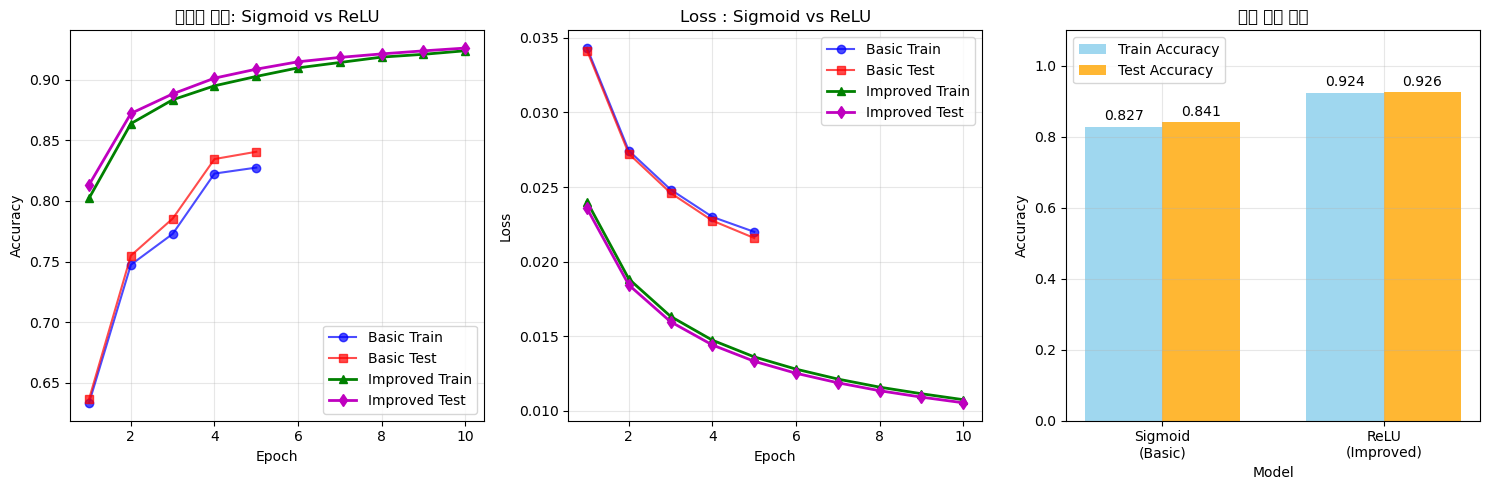


=== 추가 개선 방안 제안 ===
1. 드롭아웃 적용으로 과적합 방지
2. 배치 정규화로 학습 안정성 향상
3. Adam 옵티마이저 사용
4. 더 깊은 네트워크 (3개 이상의 은닉층)
5. 데이터 증강 (Data Augmentation)
6. 학습률 스케줄링 (Learning Rate Scheduling)
7. 앨샘블 방법 (Ensemble)

90% 이상의 정확도를 달성했습니다.

Test Accuracy를 0.841에서 0.926로 향상시켰습니다.


In [12]:
# 1-7번 문제: 더 높은 Test data 정확도를 위한 개선 방안

print("=== 1-7번 문제: 성능 개선 방안 ===")

# 현재 결과 분석
print(f"현재 결과 분석:")
print(f"- 최종 테스트 정확도: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
print(f"- 훈련/테스트 정확도 차이: {final_train_acc - final_test_acc:.4f}")
if final_train_acc - final_test_acc > 0.05:
    print("  → 과적합(Overfitting) 경향이 있습니다.")

print("\n성능 개선 방안:")
print("1. 활성화 함수 변경 (Sigmoid → ReLU)")
print("2. 더 깊은 네트워크 구조")
print("3. 드롭아웃(Dropout) 적용")
print("4. 배치 정규화(Batch Normalization)")
print("5. 더 많은 에폭 학습")
print("6. 학습률 스케줄링")
print("7. 더 좋은 가중치 초기화")

print("\n=== 개선 방안 1: ReLU 활성화 함수 사용 ===")

# ReLU 네트워크 생성
network_relu = MultiLayerNet(
    input_size=784,
    hidden_size_list=[100, 50],
    output_size=10,
    activation='relu',        # ReLU 활성화 함수
    weight_init_std='relu'    # ReLU에 적합한 He 초기화
)

print("ReLU 네트워크 생성 완료")

# 개선된 학습 파라미터
learning_rate_improved = 0.01  # 더 작은 학습률
epochs_improved = 10          # 더 많은 에폭
batch_size_improved = 100     # 더 작은 배치 사이즈

print(f"\n개선된 학습 조건:")
print(f"- 활성화 함수: ReLU")
print(f"- 가중치 초기화: He initialization")
print(f"- 학습률: {learning_rate_improved}")
print(f"- 배치 사이즈: {batch_size_improved}")
print(f"- 에폽 수: {epochs_improved}")

# 옵티마이저 설정
optimizer_improved = SGD(lr=learning_rate_improved)

# 학습 기록을 위한 리스트
train_loss_improved = []
test_loss_improved = []
train_acc_improved = []
test_acc_improved = []

print(f"\n=== 개선된 모델 학습 시작 ===")

# 에폽당 배치 수
batches_per_epoch_improved = len(X_train_flat) // batch_size_improved

for epoch in range(epochs_improved):
    print(f"\nEpoch {epoch+1}/{epochs_improved}")
    
    # 미니배치 학습
    epoch_losses = []
    for X_batch, y_batch in tqdm(shuffle_batch(X_train_flat, y_train_onehot, batch_size_improved),
                                total=batches_per_epoch_improved,
                                desc=f"Epoch {epoch+1}"):
        
        # Forward & Backward
        loss = network_relu.loss(X_batch, y_batch)
        grads = network_relu.gradient(X_batch, y_batch)
        
        # 가중치 업데이트
        optimizer_improved.update(network_relu.params, grads)
        epoch_losses.append(loss)
    
    # 에폭 종료 후 평가
    # 훈련 데이터 평가
    train_losses = []
    train_accs = []
    for X_batch, y_batch in shuffle_batch(X_train_flat, y_train_onehot, 1000):
        train_loss = network_relu.loss(X_batch, y_batch)
        train_acc = network_relu.accuracy(X_batch, y_batch)
        train_losses.append(train_loss * len(X_batch))
        train_accs.append(train_acc * len(X_batch))
    
    # 테스트 데이터 평가
    test_losses = []
    test_accs = []
    for X_batch, y_batch in shuffle_batch(X_test_flat, y_test_onehot, 1000):
        test_loss = network_relu.loss(X_batch, y_batch)
        test_acc = network_relu.accuracy(X_batch, y_batch)
        test_losses.append(test_loss * len(X_batch))
        test_accs.append(test_acc * len(X_batch))
    
    # 가중평균
    epoch_train_loss = sum(train_losses) / len(X_train_flat)
    epoch_train_acc = sum(train_accs) / len(X_train_flat)
    epoch_test_loss = sum(test_losses) / len(X_test_flat)
    epoch_test_acc = sum(test_accs) / len(X_test_flat)
    
    # 기록
    train_loss_improved.append(epoch_train_loss)
    train_acc_improved.append(epoch_train_acc)
    test_loss_improved.append(epoch_test_loss)
    test_acc_improved.append(epoch_test_acc)
    
    # 결과 출력 (5 에폽마다)
    if (epoch + 1) % 2 == 0 or epoch == 0 or epoch == epochs_improved - 1:
        print(f"Epoch {epoch+1}: Train Acc: {epoch_train_acc:.4f}, Test Acc: {epoch_test_acc:.4f}")

print("\n=== 개선 결과 비교 ===")

# 결과 비교
final_train_acc_improved = train_acc_improved[-1]
final_test_acc_improved = test_acc_improved[-1]

print(f"\n기본 모델 (Sigmoid):")
print(f"  Train Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  Test Accuracy:  {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")

print(f"\n개선 모델 (ReLU):")
print(f"  Train Accuracy: {final_train_acc_improved:.4f} ({final_train_acc_improved*100:.2f}%)")
print(f"  Test Accuracy:  {final_test_acc_improved:.4f} ({final_test_acc_improved*100:.2f}%)")

print(f"\n성능 개선:")
test_improvement = final_test_acc_improved - final_test_acc
print(f"  Test Accuracy 개선: {test_improvement:.4f} ({test_improvement*100:.2f}%p)")

if test_improvement > 0:
    print(f"   성공: {test_improvement*100:.2f}%p 성능 향상!")
else:
    print(f"   경고: 성능 개선이 없습니다.")

# 비교 시각화
plt.figure(figsize=(15, 5))

# 1. 정확도 비교
plt.subplot(1, 3, 1)
epochs_basic = range(1, len(train_acc_history)+1)
epochs_improved = range(1, len(train_acc_improved)+1)

plt.plot(epochs_basic, train_acc_history, 'b-', label='Basic Train', marker='o', alpha=0.7)
plt.plot(epochs_basic, test_acc_history, 'r-', label='Basic Test', marker='s', alpha=0.7)
plt.plot(epochs_improved, train_acc_improved, 'g-', label='Improved Train', marker='^', linewidth=2)
plt.plot(epochs_improved, test_acc_improved, 'm-', label='Improved Test', marker='d', linewidth=2)

plt.title('정확도 비교: Sigmoid vs ReLU')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. 손실값 비교
plt.subplot(1, 3, 2)
plt.plot(epochs_basic, train_loss_history, 'b-', label='Basic Train', marker='o', alpha=0.7)
plt.plot(epochs_basic, test_loss_history, 'r-', label='Basic Test', marker='s', alpha=0.7)
plt.plot(epochs_improved, train_loss_improved, 'g-', label='Improved Train', marker='^', linewidth=2)
plt.plot(epochs_improved, test_loss_improved, 'm-', label='Improved Test', marker='d', linewidth=2)

plt.title('Loss : Sigmoid vs ReLU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. 최종 성능 비교
plt.subplot(1, 3, 3)
models = ['Sigmoid\n(Basic)', 'ReLU\n(Improved)']
test_accuracies = [final_test_acc, final_test_acc_improved]
train_accuracies = [final_train_acc, final_train_acc_improved]

x_pos = np.arange(len(models))
width = 0.35

plt.bar(x_pos - width/2, train_accuracies, width, label='Train Accuracy', alpha=0.8, color='skyblue')
plt.bar(x_pos + width/2, test_accuracies, width, label='Test Accuracy', alpha=0.8, color='orange')

# 수치 표시
for i, (train_acc, test_acc) in enumerate(zip(train_accuracies, test_accuracies)):
    plt.text(i - width/2, train_acc + 0.01, f'{train_acc:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, test_acc + 0.01, f'{test_acc:.3f}', ha='center', va='bottom')

plt.title('최종 성능 비교')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(x_pos, models)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("\n=== 추가 개선 방안 제안 ===")
print("1. 드롭아웃 적용으로 과적합 방지")
print("2. 배치 정규화로 학습 안정성 향상")
print("3. Adam 옵티마이저 사용")
print("4. 더 깊은 네트워크 (3개 이상의 은닉층)")
print("5. 데이터 증강 (Data Augmentation)")
print("6. 학습률 스케줄링 (Learning Rate Scheduling)")
print("7. 앨샘블 방법 (Ensemble)")

if final_test_acc_improved > 0.95:
    print(f"\n95% 이상의 정확도를 달성했습니다.")
elif final_test_acc_improved > 0.90:
    print(f"\n90% 이상의 정확도를 달성했습니다.")

print(f"\nTest Accuracy를 {final_test_acc:.3f}에서 {final_test_acc_improved:.3f}로 향상시켰습니다.")